<img src="../part_of_cover_bakker_post.png" width="800px">

The Python code provided below is from <br>
**Analytical Groundwater Modeling: Theory and Applications Using Python** <br>
by *Mark Bakker and Vincent Post* <br>
ISBN 9781138029392

The book is published by CRC press and is available [here](https://www.routledge.com/Analytical-Groundwater-Modeling-Theory-and-Applications-using-Python/Bakker-Post/p/book/9781138029392).

This Notebook is provided under the [MIT license](https://github.com/pythongroundwaterbook/analytic_gw_book/blob/main/LICENSE). 

<p>© 2022 Mark Bakker and Vincent Post</p>

# Transient one-dimensional flow 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 3) # set default figure size
plt.rcParams["figure.autolayout"] = True # same at tight_layout after every plot

## Step changes in surface water level

<img src="figs/fig5.1.png" width=400>

In [2]:
# parameters
T = 100 # transmissivity, m^2/d
S = 0.2 # storage coefficient, -
delh = 2 # change in river level, m
t0 = 0 # time of change in river level, d

In [3]:
# solution
from scipy.special import erfc

def h_edelman(x, t, T, S, delh=1, t0=0):
    u = np.sqrt(S * x ** 2 / (4 * T * (t - t0)))
    return delh * erfc(u)

def Qx_edelman(x, t, T, S, delh, t0=0):
    u = np.sqrt(S * x ** 2 / (4 * T * (t - t0)))
    return T * delh * 2 * u / (x * np.sqrt(np.pi)) * np.exp(-u ** 2) 

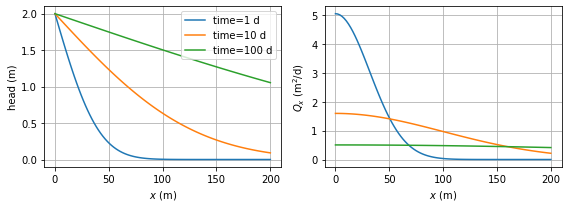

In [4]:
# basic plot head and Qx vs x
x = np.linspace(1e-12, 200, 100)
plt.subplot(121)
for t in [1, 10, 100]:
    h = h_edelman(x, t, T, S, delh, t0)
    plt.plot(x, h, label=f'time={t} d')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.legend()
plt.subplot(122)
for t in [1, 10, 100]:
    Qx = Qx_edelman(x, t, T, S, delh, t0)
    plt.plot(x, Qx, label=f'time={t} d')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)');

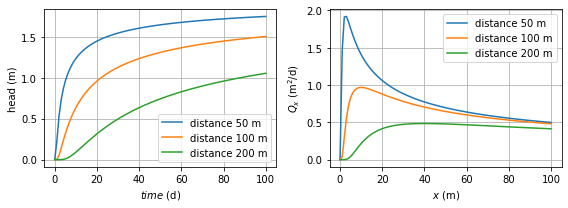

In [5]:
# basic plot head and Qx vs t
t = np.linspace(1e-12, 100, 100)
plt.subplot(121)
for x in [50, 100, 200]:
    h = h_edelman(x, t, T, S, delh, t0)
    plt.plot(t, h, label=f'distance {x} m')
plt.grid()
plt.xlabel('$time$ (d)')
plt.ylabel('head (m)')
plt.legend()
plt.subplot(122)
for x in [50, 100, 200]:
    Qx = Qx_edelman(x, t, T, S, delh, t0)
    plt.plot(t, Qx, label=f'distance {x} m')
plt.grid()
plt.xlabel('$x$ (m)')
plt.ylabel('$Q_x$ (m$^2$/d)')
plt.legend();

In [6]:
x = 100 # m
t = 10 # d
T = 100 # m^2/d
S = 0.2 # -
print(f'head at x = {x} m, t = {t} d for T = {T} and S = {S}:')
print(f'u = {np.sqrt(S * x ** 2 / (4 * T * t)):.3f}')
print(f'h = {h_edelman(x, t, T, S, delh):.6f} m')

head at x = 100 m, t = 10 d for T = 100 and S = 0.2:
u = 0.707
h = 0.634621 m


In [7]:
t = 0.1 # d
S = 0.002 # -
print(f'head at x = {x} m, t = {t} d for T = {T} and S = {S}:')
print(f'u = {np.sqrt(S * x ** 2 / (4 * T * t)):.3f}')
print(f'h = {h_edelman(x, t, T, S, delh):.6f} m')

head at x = 100 m, t = 0.1 d for T = 100 and S = 0.002:
u = 0.707
h = 0.634621 m


In [8]:
delt = 10 # time period for which water balance is checked
Qin = 2 * delh * np.sqrt(S * T * delt / (np.pi))
from scipy.integrate import quad
stored = S * quad(h_edelman, 1e-12, np.infty, args=(delt, T, S, delh, 0))[0]
print(f'total inflow from river  : {Qin:.6f} m^3')
print(f'total increase in storage: {stored:.6f} m^3')

total inflow from river  : 3.191538 m^3
total increase in storage: 3.191538 m^3


In [9]:
delh = np.array([1, 1, -2, 1]) # sequence of river stage changes, m
t0 = np.array([0, 10, 20, 30]) # sequence of times of changes, d

In [10]:
# solution
t = np.linspace(1e-3, 40, 400) # start jus after t=0
h10 = np.zeros(len(t))
h100 = np.zeros(len(t))
for i in range(len(t0)):
    h10[t > t0[i]] += h_edelman(10, t[t > t0[i]], T, S, delh[i], t0[i])
    h100[t > t0[i]] += h_edelman(100, t[t > t0[i]], T, S, delh[i], t0[i])

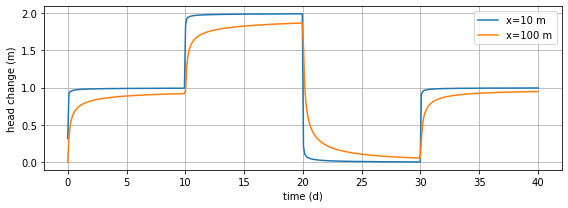

In [11]:
# basic plot head (bottom graph)
plt.plot(t, h10, label='x=10 m')
plt.plot(t, h100, label='x=100 m')
plt.grid()
plt.xlabel('time (d)')
plt.ylabel('head change (m)')
plt.legend();

## Periodic changes in surface water level

<img src="figs/fig5.2.png" width=400>

In [12]:
# parameters
T = 1000 # transmissivity, m^2/d
S = 0.1 # storate coefficient, -
tau = 0.5 # tidal period, d
tp = 0 # time of peak at canal, d
mu = np.sqrt(T * tau / (S * np.pi)) # characteristic length, m
print(f'characteristic length: {mu:.2f} m')

characteristic length: 39.89 m


In [13]:
# solution for unit amplitude
def head(x, t, tau, S, T, tp=0, t0=0):
    B = np.exp(-x * np.sqrt(S * np.pi / (T * tau)))
    ts = x * np.sqrt(S * tau / (4 * np.pi * T))
    return B * np.cos(2 * np.pi * (t - tp - ts) / tau)

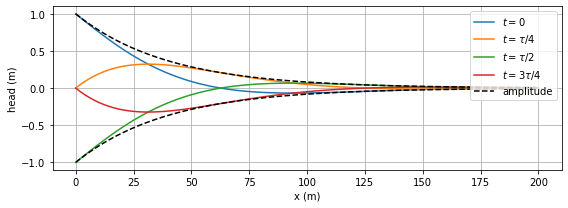

In [14]:
# basic plot
x = np.linspace(0, 200, 100)
for t in np.arange(0, tau, tau / 4):
    h = head(x, t, tau, S, T, tp)
    plt.plot(x, h)
plt.plot(x, np.exp(-x / mu), 'k--')
plt.plot(x, -np.exp(-x / mu), 'k--')
plt.legend(['$t=0$', '$t=\\tau/4$', '$t=\\tau/2$', '$t=3\\tau/4$', 'amplitude'],
           loc='upper right')
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.grid();

In [15]:
# parameters
tau1 = 745 / (24 * 60) # M2 period, d
tau2 = 1549 / (24 * 60) # O1 period, d
tp1 = 0 # time of peak M2, d
tp2 = 100 / (24 * 60) # time of peak of O1, d
mu1 = np.sqrt(T * tau1 / (S * np.pi)) # characteristic length M2, m
mu2 = np.sqrt(T * tau2 / (S * np.pi)) # characteristic length O1, m
print(f'characteristic length M2: {mu1:.2f} m')
print(f'characteristic length O1: {mu2:.2f} m')

characteristic length M2: 40.58 m
characteristic length O1: 58.52 m


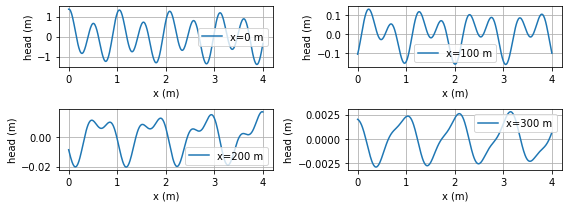

In [16]:
# basic plot
t = np.linspace(0, 4, 400)
for i, x in enumerate([0, 100, 200, 300]):
    h = 1 * head(x, t, tau1, S, T, tp1) + \
        0.4 * head(x, t, tau2, S, T, tp2)
    plt.subplot(2, 2, i + 1)
    plt.plot(t, h, label=f'x={x} m')
    plt.xlabel('time (d)')
    plt.ylabel('head (m)')
    plt.grid()
    plt.legend();

## Areal recharge between two rivers

<img src="figs/fig5.3.png" width=400>

In [17]:
# parameters
L = 1000 # aquifer length, m
S = 0.1 # storage coefficient, -
T = 200 # transmissivity, m^2/d
N = 0.001 # recharge rate, m/d

In [18]:
# solution
def head(x, t, T=T, S=S, L=L, N=N, nterms=10):
    h = 0
    for n in range(nterms):
        h += (-1)**n / (2 * n + 1)**3 * \
        np.cos(((2 * n + 1) * np.pi * x) / L) * \
        np.exp(-((2 * n + 1)**2 * np.pi**2 * T * t) / (S * L**2))
    h = -N / (2 * T) * (x**2 - L**2/4) - 4 * N * L**2 / (np.pi**3 * T) * h
    return h

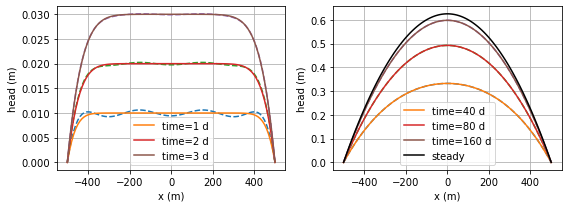

In [19]:
# basic head plot
plt.subplot(121) # early time
x = np.linspace(-L / 2, L / 2, 100)
for t in [1, 2, 3]: 
    plt.plot(x, head(x, t, nterms=3), '--')
    plt.plot(x, head(x, t, nterms=10), label=f'time={t} d')
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.legend()
plt.grid()
plt.subplot(122) # late time
for t in [40, 80, 160]:
    plt.plot(x, head(x, t, nterms=1) , '--') # just 1 term is enough
    plt.plot(x, head(x, t, nterms=10), label=f'time={t} d')
plt.plot(x, head(x, 0, nterms=0), 'k', label='steady'); # 0 terms gives steady solution
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();

In [20]:
t95 = 3 * S * L**2 / (np.pi**2 * T)
print(f'The memory of the system is: {t95:0.0f} d')

The memory of the system is: 152 d


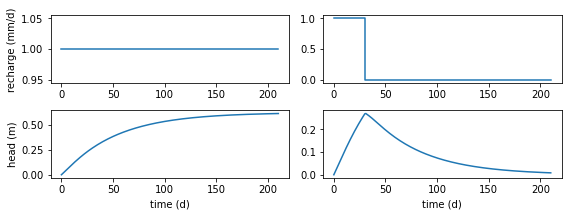

In [21]:
# plot step recharge and response and block recharge and response at x=0
x = 0
delt = 365 / 12
t = np.linspace(0, 210, 211)
plt.subplot(221)
plt.plot([0, 210], [1, 1])
plt.ylabel('recharge (mm/d)')
plt.subplot(222)
plt.plot([0, 30, 30, 210], [1, 1, 0, 0])
plt.subplot(223)
h = N * head(x, t, N=1)
plt.plot(t, h)
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.subplot(224)
h[t > delt] -= N * head(x, t[t > delt] - delt, N=1)
plt.plot(t, h)
plt.xlabel('time (d)');

In [22]:
# four years of monthly recharge data
delt = 365 / 12
recharge = 0.001 * np.array( # convert recharge from mm/d to m/d
[ 1.2,  1.5,  0.8, -1.2,  0.2, -2.9, -0.6,  2.8,  1.2,  0.9,  3.8,
  1.8,  1.9,  1.8, -0.6, -1.3, -2.5,  0.6,  0.9,  1.8, -0.3,  0.8,
 -0.2,  3.8,  2.8,  0.3, -0.5,  0.3, -1.1,  1.5,  1. , -1.5,  0.1,
  1.5,  1. ,  4. ,  1.3,  1.3,  0.3, -1.1,  0.6, -0.8, -1.2, -1.6,
  1.3,  1.4,  2.4,  2.6])
ntime = len(recharge) # number of month

In [23]:
# discrete block response
def bresponse(x, ntime, delt, T=T, S=S, L=L, nterms=10):
    t = np.linspace(delt, ntime * delt, ntime)
    return head(x, t, T, S, L, 1, nterms) - \
           head(x, t - delt, T, S, L, 1, nterms)

In [24]:
# solution
h0 = np.zeros(ntime + 1) # head at x=0
h400 = np.zeros(ntime + 1) # head at x=400
b0 = bresponse(0, ntime, delt, T, S, L)
b400 = bresponse(400, ntime, delt, T, S, L)
for n in range(1, len(recharge) + 1):
    h0[n] = np.sum(recharge[0:n] * b0[n - 1::-1])
    h400[n] = np.sum(recharge[0:n] * b400[n - 1::-1])

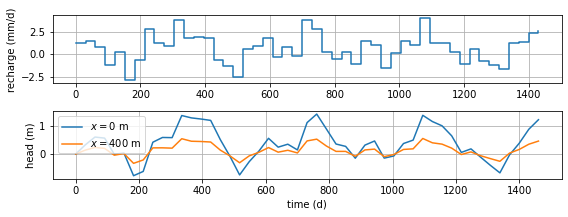

In [25]:
# basic plot recharge data and head response
plt.subplot(211)
time = np.linspace(0, ntime * delt, ntime + 1)
plt.step(time[:-1], 1000 * recharge, where='post'); # plt.stairs in mpl>=3.4
plt.ylabel('recharge (mm/d)')
plt.grid()
plt.subplot(212)
plt.plot(time, h0, label='$x=0$ m')
plt.plot(time, h400, label='$x=400$ m')
plt.grid()
plt.xlabel('time (d)')
plt.ylabel('head (m)')
plt.legend();

In [26]:
def simplebresponse(A, a, delt, nstep):
    t = np.linspace(0, nstep * delt, nstep + 1)
    hstep = A * (1 - np.exp(-t / a))
    return hstep[1:] - hstep[:-1]

In [27]:
def fobj(p, delt=delt, recharge=recharge, hobs=h0, return_heads=False):
    A, a = p
    ntime = len(recharge)
    b = simplebresponse(A, a, delt, ntime + 1)
    hm = np.zeros(ntime + 1)
    for n in range(1, ntime + 1):
        hm[n] = np.sum(recharge[0:n] * b[n - 1::-1])
    if return_heads:
        return hm
    rv = np.sum((hobs - hm) ** 2)
    return rv

In [28]:
from scipy.optimize import fmin
A, a = fmin(fobj, [300, 50], disp=0)
print(f'Estimated parameters A: {A:.2f} d, a: {a:.2f} d')
hm = fobj([A, a], return_heads=True) # compute modeled heads

Estimated parameters A: 629.89 d, a: 53.03 d


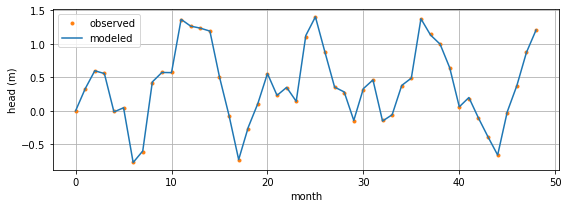

In [29]:
# basic plot modeled heads
plt.plot(h0, 'C1.', label='observed')
plt.plot(hm, 'C0', label='modeled')
plt.xlabel('month')
plt.ylabel('head (m)')
plt.grid()
plt.legend();

## Solutions with Laplace transforms

In [30]:
# coefficients V_k
from scipy.special import factorial as fac
def stehfest_coef(M):
    assert M % 2 == 0, 'M must be even' # make sure M is even
    M2 = int(M / 2)
    V = np.zeros(M)
    for k in range(1, M + 1):
        z = np.zeros(min(k, M2) + 1)
        for j in range(int((k + 1) / 2), min(k, M2) + 1):
            z[j] = j ** M2 * fac(2 * j) / \
            (fac(M2 - j) * fac(j) * fac(j - 1) * fac(k - j) * fac(2 * j - k))
        V[k - 1] = (-1) ** (k + M2) * np.sum(z)
    return V

In [31]:
# Stehfest algorithm
def stehfest(x, t, func, M=12, **kwargs):
    t = np.atleast_1d(t)
    x = np.atleast_1d(x)
    f = np.zeros((len(x), len(t)))
    V = stehfest_coef(M)
    for i in range(len(t)):
        p = np.arange(1, M + 1) * np.log(2) / t[i]
        for j in range(len(x)):
            fbar = func(p, x[j], **kwargs)
            f[j, i] = np.log(2) / t[i] * np.sum(V * fbar)
    return f

In [32]:
# parameters
T = 100 # transmissivity, m^2/d
S = 0.2 # storage coefficient, -
delh = 2 # increase in river level, m

In [33]:
# Laplace-transformed solution
def hbar(p, x, T=100, S=1e-3, delh=2):
    return delh / p * np.exp(-x * np.sqrt(p * S / T))

In [34]:
# comparison
x = 50 # location, m
t = 10 # time, d
M = 12 # number of terms
V = stehfest_coef(M)
hx = h_edelman(x, t, T, S, delh=2) # from Section 5.1
hs = stehfest(x, t, hbar, M=M, T=T, S=S)
print(f'Exact head at x={x} m and t={t} d: {hx}')
print(f'Stehfest head with M={M} terms  : {hs}')
print(f'Relative error: {(hs - hx) / hx}')

Exact head at x=50 m and t=10 d: 1.2341501549039475
Stehfest head with M=12 terms  : [[1.23415675]]
Relative error: [[5.34721333e-06]]


In [35]:
Mlist = np.arange(2, 33, 2)
error = np.zeros(len(Mlist))
for i, M in enumerate(Mlist):
    hs = stehfest(x, t, hbar, M=M, T=T, S=S)
    error[i] = np.abs((hs - hx) / hx)

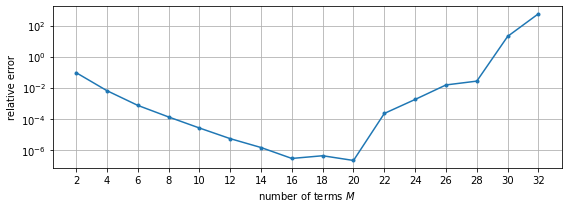

In [36]:
# simple plot
plt.semilogy(Mlist, error, '-', marker='.')
plt.xticks(np.arange(2, 33, 2))
plt.xlabel('number of terms $M$')
plt.ylabel('relative error')
plt.grid();

In [37]:
# solution
x = np.linspace(1e-12, 200, 100)
t = [1, 10, 100]
hx = np.empty((len(x), 3))
for itime in range(3):
    hx[:, itime] = h_edelman(x, t[itime], T, S, delh) # h_edelman from Sec. 2.1
hs = stehfest(x, t, hbar, M=12, T=T, S=S)

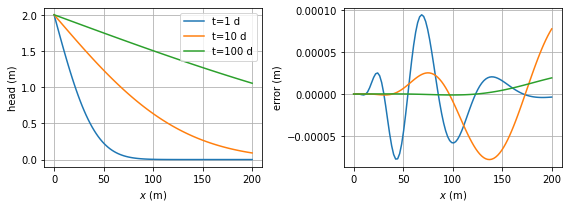

In [38]:
# basic plot head and error
plt.subplot(121)
plt.plot(x, hs)
plt.xlabel('$x$ (m)')
plt.ylabel('head (m)')
plt.grid()
plt.legend(['t=1 d', 't=10 d', 't=100 d'])
plt.subplot(122)
plt.plot(x, hs - hx)
plt.xlabel('$x$ (m)')
plt.ylabel('error (m)')
plt.grid();

## Unconfined flow with variable transmissivity

In [39]:
# parameters
k = 10 # hydraulic conductivity, m
zb = 0 # aquifer base, m
Sy = 0.2 # phreatic storage coefficient, -
h0 = 10 # initial head and canal level, m
delh = 2 # change in canal level, m
Ht = h0 + 0.5 * delh # linearized saturated thickness, m

In [40]:
from scipy.special import erfc
def h_unconfined(x, t, k, H, S, zb, h0, delh):
    pot0 = 0.5 * k * (h0 - zb) ** 2
    delpot = 0.5 * k * (h0 + delh - zb) ** 2 - pot0
    u = np.sqrt(S * x ** 2 / (4 * k * H * t))
    pot = delpot * erfc(u) + pot0
    return zb + np.sqrt(2 * pot / k)

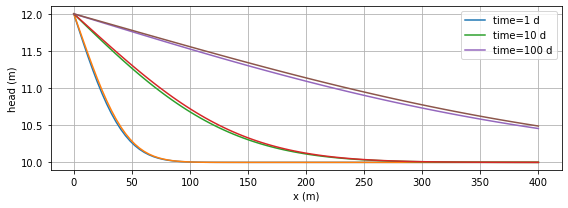

In [41]:
# basic plot head
x = np.linspace(1e-12, 400, 100)
for t in [1, 10, 100]:
    h = h_edelman(x, t, k * Ht, Sy, delh) + h0 # from Section 5.1
    plt.plot(x, h, label=f'time={t} d')
    hun = h_unconfined(x, t, k, Ht, Sy, zb, h0, delh)
    plt.plot(x, hun)
plt.xlabel('x (m)')
plt.ylabel('head (m)')
plt.legend()
plt.grid();